Author: Cyrille, cyrille@bayesimpact.org

Date: 2018-04-09

# ROME update from v333 to v334

In March 2018 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v334. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '333'
NEW_VERSION = '334'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


So we have the same set of files in both versions: good start.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=pd.read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=pd.read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

All files have the same columns as before: still good.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

14/30720 values added in unix_coherence_item_v334_utf8.csv
31/11677 values added in unix_cr_gd_dp_appellations_v334_utf8.csv
15108/16308 values removed in unix_item_arborescence_v334_utf8.csv
6/13387 values added in unix_item_v334_utf8.csv
45/42273 values added in unix_liens_rome_referentiels_v334_utf8.csv
31/11021 values added in unix_referentiel_appellation_v334_utf8.csv
1/4948 values added in unix_referentiel_competence_v334_utf8.csv
2/5039 values added in unix_texte_v334_utf8.csv
13/21 files with the same number of rows


There are some minor changes in many files, except for the arborescence, which seems to have lost most of its content.

## Climbing up the arborescence tree 

Let's look into `arborescence` more deeply, before looking at other files (a brief presentation of the tree structure in this dataset is done in [this notebook](../../research/jobbing/jobs_without_qualifications.ipynb)).
It's describing a large tree of concepts grouped in 5 main subtrees defined by the code_type_referentiel field. In Bob we mainly use the branch Métiers accessibles sans diplôme et sans expérience of the subtree 7(code ROME).

In [6]:
arborescence = find_rome_dataset_by_name(rome_data, 'item_arborescence')

old_roots = arborescence.old[arborescence.old.libelle_type_noeud == 'RACINE']
new_roots = arborescence.new[arborescence.new.libelle_type_noeud == 'RACINE']

old = old_roots[['code_type_referentiel', 'libelle_item_arbo']]
new = new_roots[['code_type_referentiel', 'libelle_item_arbo']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged.head()

,code_type_referentiel,libelle_item_arbo,_merge,_diff
0,10,Racine de l''arborescence d''item - environnem...,left_only,removed
1,6,Racine de l''arborescence principale,both,NaN
2,7,Racine de l''arborescence secondaire - code ROME,both,NaN
3,8,Racine de l''arborescence d''item - activite,left_only,removed
4,9,Racine de l''arborescence d''item - competence,left_only,removed


So three branches of the arborescence were trimmed, while the other two are kept. Subtrees for 'environnement de travail', 'activite' and 'competence' have been cut, while the principal subtree and the ROME subtree have been kept. According to "Pôle emploi", 'environnement de travail' was removed because it was done by hand and largely incomplete. The other two have been renamed 'savoir-faire' and 'savoirs', and moved outside the ROME (not sure where exactly, though).

Let's see if there is much change in this file, once those subtrees are removed: 

In [7]:
is_old_obsolete = arborescence.old.code_type_referentiel.isin(
    links_merged.code_type_referentiel[links_merged._diff == 'removed'])
old_arborescence_trimmed = arborescence.old[~is_old_obsolete]

obsolete_arborescence_titles = set(
    old_arborescence_trimmed.libelle_item_arbo) - set(
    arborescence.new.libelle_item_arbo)
new_arborescence_titles = set(
    arborescence.new.libelle_item_arbo) - set(
    old_arborescence_trimmed.libelle_item_arbo)

print('Titles removed: "{}"'.format('", "'.join(obsolete_arborescence_titles)))
print('Titles added: "{}"'.format('", "'.join(new_arborescence_titles)))



Titles removed: "Sécurité et protection santé du BTP"
Titles added: "Qualité Sécurité Environnement et protection santé du BTP"


Hmm... Only one obsolete and one new title, and they seem quite similar. Let's try and replace the old one with the new one, and compare the datasets.

In [8]:
arborescence.old.loc[~is_old_obsolete, 'libelle_item_arbo'] = old_arborescence_trimmed.libelle_item_arbo.str.replace(
    'Sécurité et protection santé du BTP',
    'Qualité Sécurité Environnement et protection santé du BTP', regex=False)

arborescence.old[arborescence.old.libelle_item_arbo == 'Sécurité et protection santé du BTP']

,code_ogr,code_type_referentiel,code_pere,code_noeud,libelle_item_arbo,code_item_arbo_associe,code_type_noeud,libelle_type_noeud,statut


In [9]:
arborescence.old[~is_old_obsolete].reset_index(drop=True).to_json() == arborescence.new.reset_index(drop=True).to_json()

True

Ok, so apart from changing a title, they are actually the same!

So this dataset has seen a major change, but it is limited to dropping some branches
and we weren't using them anyway, so this does not bother us too much.

Let's take a look at the changes in the other datasets, especially those of interest to us.

## Other changes

The most interesting ones are in `referentiel_appellation`, `item`, and `liens_rome_referentiels`, so let's see more precisely.

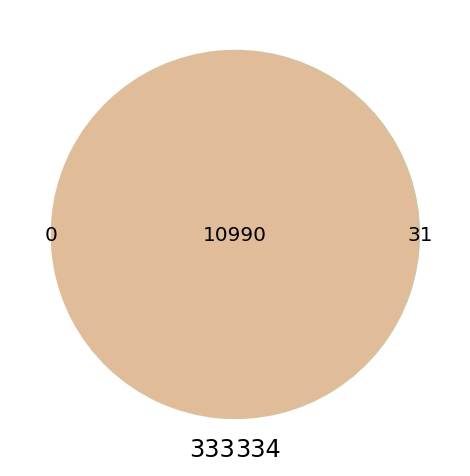

In [10]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 31 new jobs added. Let's take a look (only showing interesting fields):

In [11]:
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
3850,140877,Conducteur / Conductrice de tracteur enjambeur,A1101
3851,140878,Adjoint / Adjointe au responsable QSE - Qualit...,F1204
3852,140879,Animateur / Animatrice QSE - Qualité Sécurité ...,F1204
3854,140880,Chargé / Chargée de mission QSE - Qualité Sécu...,F1204
3855,140881,Ingénieur / Ingénieure HSE - Hygiène Sécurité ...,F1204
3856,140882,Ingénieur /Ingénieure QHSE - Qualité Hygiène S...,F1204
3857,140883,Responsable qualité sécurité développement dur...,F1204
3858,140884,Responsable HSE - Hygiène Sécurité Environneme...,F1204
3859,140885,Responsable QSE - Qualité Sécurité Environneme...,F1204
3860,140886,Technicien / Technicienne QSE - Qualité Sécuri...,F1204


There seems to be a few different domain where new jobs were added, mainly construction security and sport instructors.

OK, let's check at the changes in items:

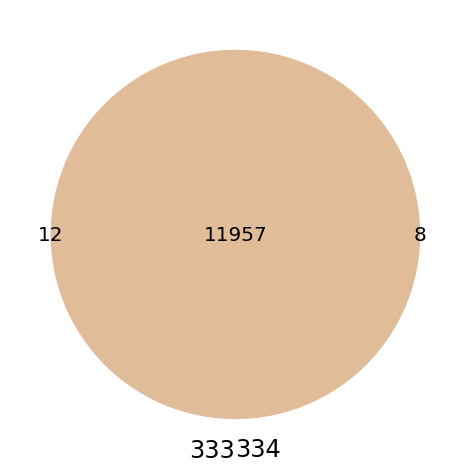

In [12]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): some items are now obsolete and new ones have been created. Let's have a look.

In [13]:
items.old[items.old.code_ogr.isin(obsolete_items)].tail()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
9721,123269,Organiser le planning d''un chantier,2,6,NaN,NaN,NaN
9925,123523,Conditionner un produit artisanal,2,9,NaN,NaN,NaN
11372,125052,Moteurs hors-bord,1,10,NaN,NaN,NaN
11374,125054,Moteurs in-bord,1,10,NaN,NaN,NaN
12441,126344,Capacité professionnelle à la conduite de taxis,1,10,NaN,NaN,NaN


In [14]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
3252,106636,Superviser un parc de véhicules et engins de t...,2,9,NaN,NaN,NaN
6531,117742,Indicateurs Qualité Sécurité Environnement (QSE),1,7,NaN,NaN,NaN
7488,119783,Réaliser un suivi des carrières,2,9,NaN,NaN,NaN
7759,120445,Pratique de la randonnée,1,10,NaN,NaN,NaN
9817,123385,Gérer la location d''un patrimoine immobilier,2,9,NaN,NaN,NaN


Those entries look legitimate.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [15]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added      167
removed    149
Name: _diff, dtype: int64

So in addition to the added and removed items, there are 316 fixes. Let's have a look:

In [16]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').old.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
links_merged[links_merged._diff == 'added'].head()

,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
30692,C1502,102694,right_only,added,Gestion locative immobilière,Renseigner les supports de suivi d''interventi...
30693,B1301,121060,right_only,added,Décoration d''espaces de vente et d''exposition,Former du personnel à des procédures et techni...
30694,E1203,121060,right_only,added,Production en laboratoire photographique,Former du personnel à des procédures et techni...
30695,E1202,121060,right_only,added,Production en laboratoire cinématographique,Former du personnel à des procédures et techni...
30696,E1302,102694,right_only,added,Conduite de machines de façonnage routage,Renseigner les supports de suivi d''interventi...


Those fixes make sense (not sure why they were not done before, but let's not complain: it is fixed now).

In [17]:
links_merged[links_merged._diff == 'removed'].head()

,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
134,C1502,124083,left_only,removed,Gestion locative immobilière,Réaliser des actions de communication interne
231,C1501,119084,left_only,removed,Gérance immobilière,Coordonner et superviser la gestion du patrimoine mobilier et immobilier
1124,B1301,123036,left_only,removed,Décoration d''espaces de vente et d''exposition,Former un public
2113,E1203,123036,left_only,removed,Production en laboratoire photographique,Former un public
2115,E1203,123466,left_only,removed,Production en laboratoire photographique,Sensibiliser et former les personnels aux consignes de sécurité et de prévention


Seems alright here too, those skills are not really mandatory for those jobs.

# Conclusion

The new version of ROME, v334, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf). The transition should be transparent with a very small advantage over the old version.

However, a whole part of the arborescence was dropped, without any explanation or apparent reason. It has no impact on Bob for now, since we don't use it much yet, but we should investigate the matter with Pole emploi, because we might need it more in the future.